# Yield Curve Dynamic
#### Exploring the ECB Bond Yield Curve with Python

The European Central Bank publishes the bond yield curve in a parametric form, the so-called [Svensson Model](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=883856).
$$y(t) = \beta_0 + \beta_1 \Bigg(\frac{1-e^{\frac{-t}{\tau_1}}}{t / \tau_1}\Bigg) + \beta_2 \Bigg(\frac{1-e^{\frac{-t}{\tau_1}}}{t / \tau_1} - e^{\frac{-t}{\tau_1}}\Bigg) + \beta_3 \Bigg(\frac{1-e^{\frac{-t}{\tau_2}}}{t / \tau_2} - e^{\frac{-t}{\tau_2}}\Bigg)$$

In [1]:
import numpy as np
import pandas as pd

from nelson_siegel_svensson import NelsonSiegelSvenssonCurve

In [2]:
eur_hist = pd.read_csv('../data/euryieldcurve.csv', parse_dates=['date'], index_col=0)
eur_hist.head()

,beta0,beta1,beta2,beta3,tau1,tau2
date,,,,,,
2016-01-04,2.142562,-2.649562,19.953238,-24.067787,1.656860,1.814525
2016-01-05,2.154949,-2.660949,19.918749,-24.102527,1.653682,1.814610
2016-01-06,2.127892,-2.643892,19.932320,-24.088511,1.672715,1.835135
2016-01-07,2.180033,-2.682033,19.896829,-24.122854,1.686040,1.843311
2016-01-08,2.142886,-2.659886,19.927342,-24.091999,1.691714,1.848635


In [3]:
curve = NelsonSiegelSvenssonCurve(*eur_hist.iloc[0])
curve

NelsonSiegelSvenssonCurve(beta0=2.142562, beta1=-2.649562, beta2=19.953238, beta3=-24.067787, tau1=1.6568599999999998, tau2=1.814525)

In [4]:
t = np.linspace(0,30,200)

In [5]:
from matplotlib import animation, rc
import matplotlib.pyplot as plt
from IPython.display import HTML

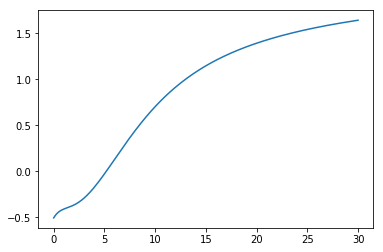

In [6]:
plt.plot(t, curve(t));

In [7]:
curves = [(ts.date(), NelsonSiegelSvenssonCurve(*param)) for ts, param in eur_hist.iterrows()]

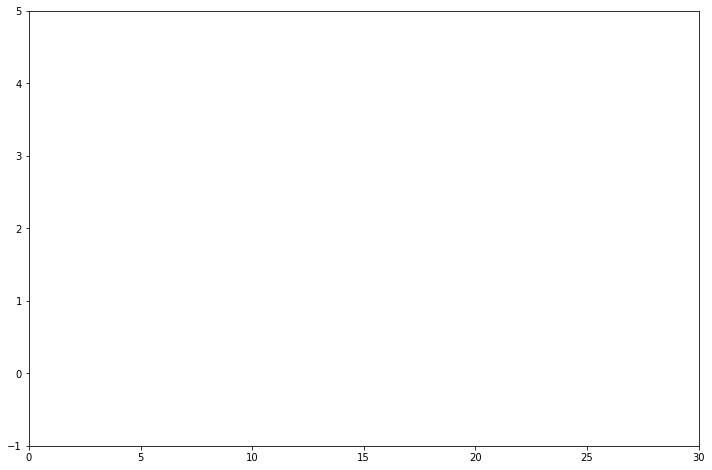

In [8]:
n_frames = 5
step = int(len(curves) / n_frames)
assert step > 0

fig, ax = plt.subplots(figsize=(12,8))
ax.set_xlim(0, 30)
ax.set_ylim(-1, 5)
ttl = ax.text(28,4.8,"")

line, = ax.plot([], [], lw=2)

def init():
    line.set_data([], [])
    return (line,)

def animate(i):
    dt, curve = curves[i*step]
    y = curve(t)
    line.set_data(t, y)
    ttl.set_text('{}-{:02d}'.format(dt.year, dt.month))
    return (line,ttl)

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=n_frames, interval=100, blit=True);

In [9]:
HTML(anim.to_jshtml())

In [10]:
HTML(anim.to_html5_video())

In [11]:
week = 1.0 / 52.0
month = 1.0 / 12.0
year = 1.0
key_tenors = np.array([0, 1*week, 2*week, 3*week, 1*month, 2*month, 3*month, 4*month, 5*month, 6*month,
                     7*month, 8*month, 9*month, 10*month, 11*month, 1*year, 2*year, 3*year, 4*year, 5*year,
                     7*year, 10*year, 15*year, 20*year, 25*year, 30*year])

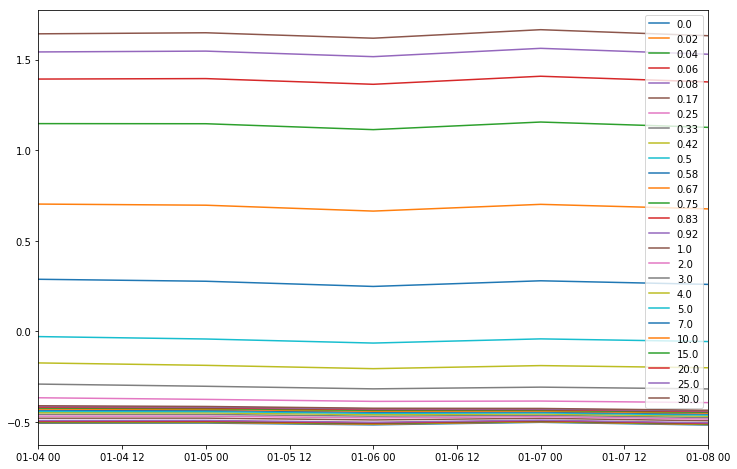

In [12]:
key_rates = pd.DataFrame([curve(key_tenors) for dt, curve in curves], columns=np.array(key_tenors).round(2), index=[dt for dt, curve in curves])
key_rates.plot(figsize=(12,8));

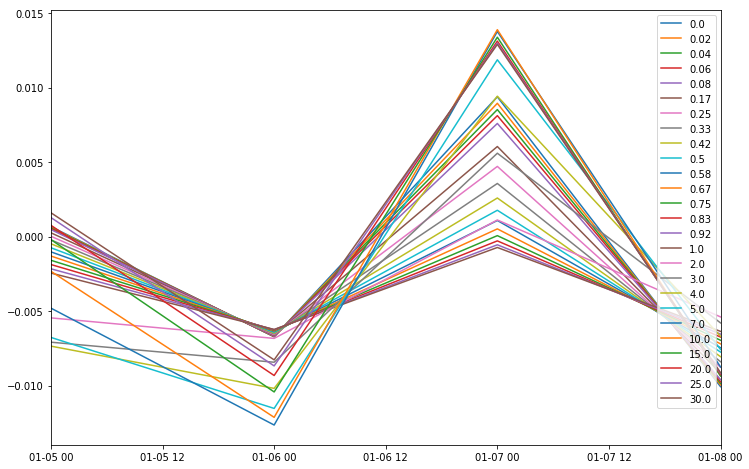

In [13]:
shifted_log_diff = np.log(key_rates + 2).diff(axis=0).iloc[1:]
shifted_log_diff.plot(figsize=(12,8));

In [14]:
from sklearn.decomposition import PCA

In [15]:
pca = PCA()
pca.fit(shifted_log_diff)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

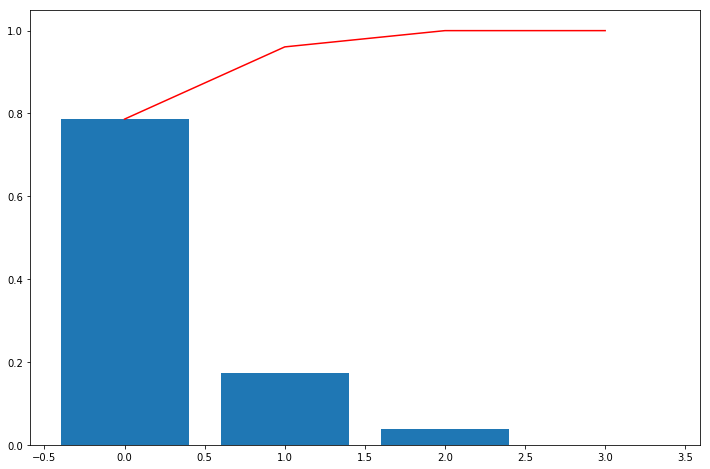

In [16]:
fig, ax = plt.subplots(figsize=(12,8))
normalized_sv = pca.singular_values_ / pca.singular_values_.sum()
ax.bar(range(len(normalized_sv)), normalized_sv);
ax.plot(np.cumsum(normalized_sv), 'r');

In [17]:
np.cumsum(normalized_sv)[:7]

array([0.78642375, 0.96074601, 1.        , 1.        ])

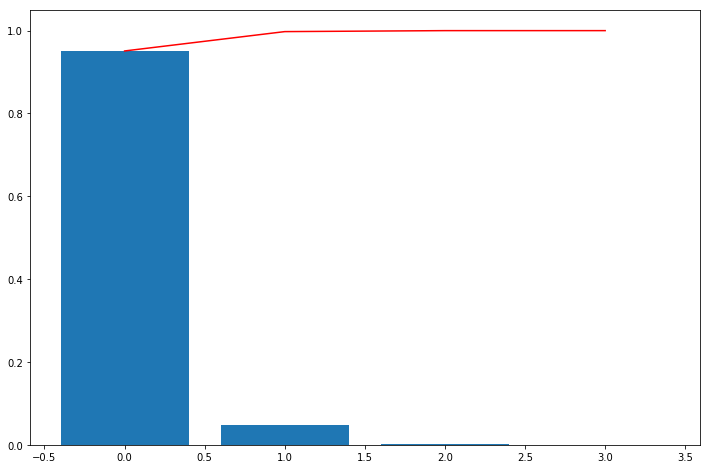

In [18]:
fig, ax = plt.subplots(figsize=(12,8))
normalized_sv = pca.explained_variance_ratio_
ax.bar(range(len(normalized_sv)), normalized_sv);
ax.plot(np.cumsum(normalized_sv), 'r');

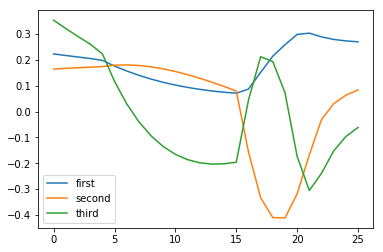

In [19]:
plt.plot(pca.components_[:3,:].T);
plt.legend(['first', 'second', 'third']);